# Introduction

In this notebook, we train selected classifier models on the training dataset using all patient data (inlcuding patients exhibiting memory complaints), and then compare their performance on the validation set. We also sometimes use hyperparamater tuning to get the best F1 score. We care about F1 scores because false negatives are critical.

In [64]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

# Set plot style
set_style("whitegrid")

## For preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

## For splitting data
from sklearn.model_selection import train_test_split

## For evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

## For building pipelines
from sklearn.pipeline import Pipeline

## Classification Models Explored
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

## Loading the data

In [66]:
## Reading the traning and testing datasets
df_train = pd.read_csv("../../data/train_set.csv")
df_test = pd.read_csv("../../data/validation_set.csv")

## Dropping redundant columns
df_train = df_train.drop(columns = ['DoctorInCharge' , 'PatientID' ])
df_test = df_test.drop(columns = ['DoctorInCharge' , 'PatientID' ])

df_train.head()

Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0   67       0          1               2  29.726811        1   
1   76       1          1               2  36.169103        1   
2   81       0          1               0  22.923111        0   
3   90       0          1               3  31.430904        0   
4   89       0          1               3  39.570099        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0           15.642599          4.605988     7.871526      7.915239  ...   
1           11.030414          9.534553     7.254090      4.364895  ...   
2            9.314832          8.917378     3.807813      9.241849  ...   
3            0.996496          7.108725     5.328610      4.977538  ...   
4            1.576700          5.712014     1.026138      4.670244  ...   

   FunctionalAssessment  MemoryComplaints  BehavioralProblems       ADL  \
0              6.088453                 1                   0  9.105791   
1              5.399515                 1                   0  4.725688   
2              4.594907                 0                   1  8.681801   
3              0.880355                 0                   0  7.805410   
4              0.293490                 0                   0  1.307295   

   Confusion  Disorientation  PersonalityChanges  DifficultyCompletingTasks  \
0          0               0                   0                          0   
1          0               0                   0                          0   
2          0               0                   0                          0   
3          0               0                   0                          0   
4          0               0                   0                          0   

   Forgetfulness  Diagnosis  
0              0          0  
1              1          1  
2              0          1  
3              0          0  
4              1          1  

[5 rows x 33 columns]

In [68]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}

# Logistic Regression

all_features      demo  lifestyle     medic  clinical  cognitive  \
Accuracy       0.860465  0.648256   0.648256  0.648256  0.648256   0.854651   
Precision      0.828829  0.000000   0.000000  0.000000  0.000000   0.825688   
Recall         0.760331  0.000000   0.000000  0.000000  0.000000   0.743802   
F1 Score       0.793103  0.000000   0.000000  0.000000  0.000000   0.782609   

           symptoms  no_cognitive  
Accuracy   0.648256      0.645349  
Precision  0.000000      0.000000  
Recall     0.000000      0.000000  
F1 Score   0.000000      0.000000

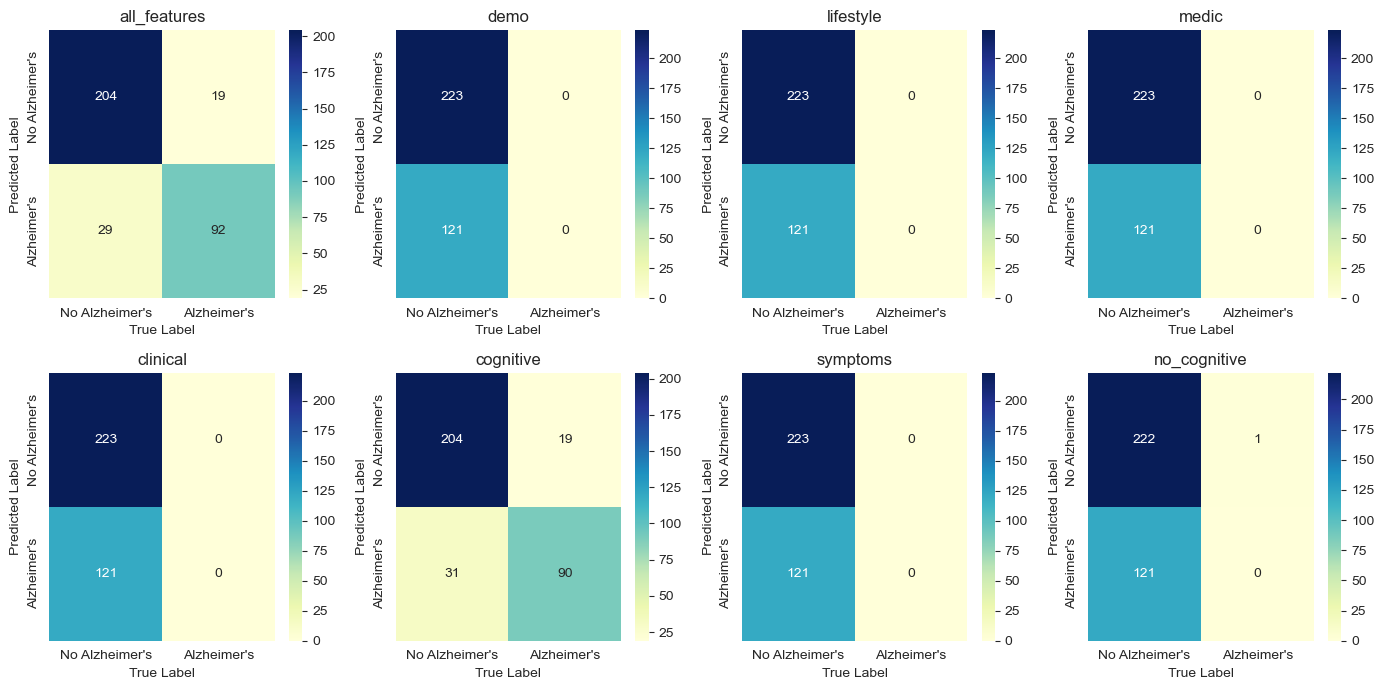

In [30]:
# Pipeline
logreg_pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('logreg', LogisticRegression(max_iter=1000))
])

# Store metrics and confusion matrices
logreg_metrics = {}
logreg_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    logreg_pipe.fit(df_train[features[:-1]], df_train.Diagnosis)
    pred = logreg_pipe.predict(df_test[features[:-1]])

    # Store metrics
    logreg_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0)
    ]

    # Store confusion matrix
    logreg_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
logreg_metrics_df = pd.DataFrame(logreg_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(logreg_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(logreg_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(key)
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(logreg_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# K-Nearest Neighbors (KNN)

We use GridSearchCV to find the best n_neighbors that optimizes our F1 score.

all_features      demo  lifestyle     medic  clinical  \
Accuracy              0.709302  0.552326   0.555233  0.465116  0.616279   
Precision             0.636364  0.322581   0.322222  0.350711  0.444444   
Recall                0.404959  0.247934   0.239669  0.611570  0.363636   
F1 Score              0.494949  0.280374   0.274882  0.445783  0.400000   
Best n_neighbors      5.000000  3.000000   3.000000  5.000000  3.000000   

                  cognitive  symptoms  no_cognitive  
Accuracy           0.936047  0.613372      0.546512  
Precision          0.938053  0.357143      0.315789  
Recall             0.876033  0.123967      0.247934  
F1 Score           0.905983  0.184049      0.277778  
Best n_neighbors   3.000000  3.000000      3.000000

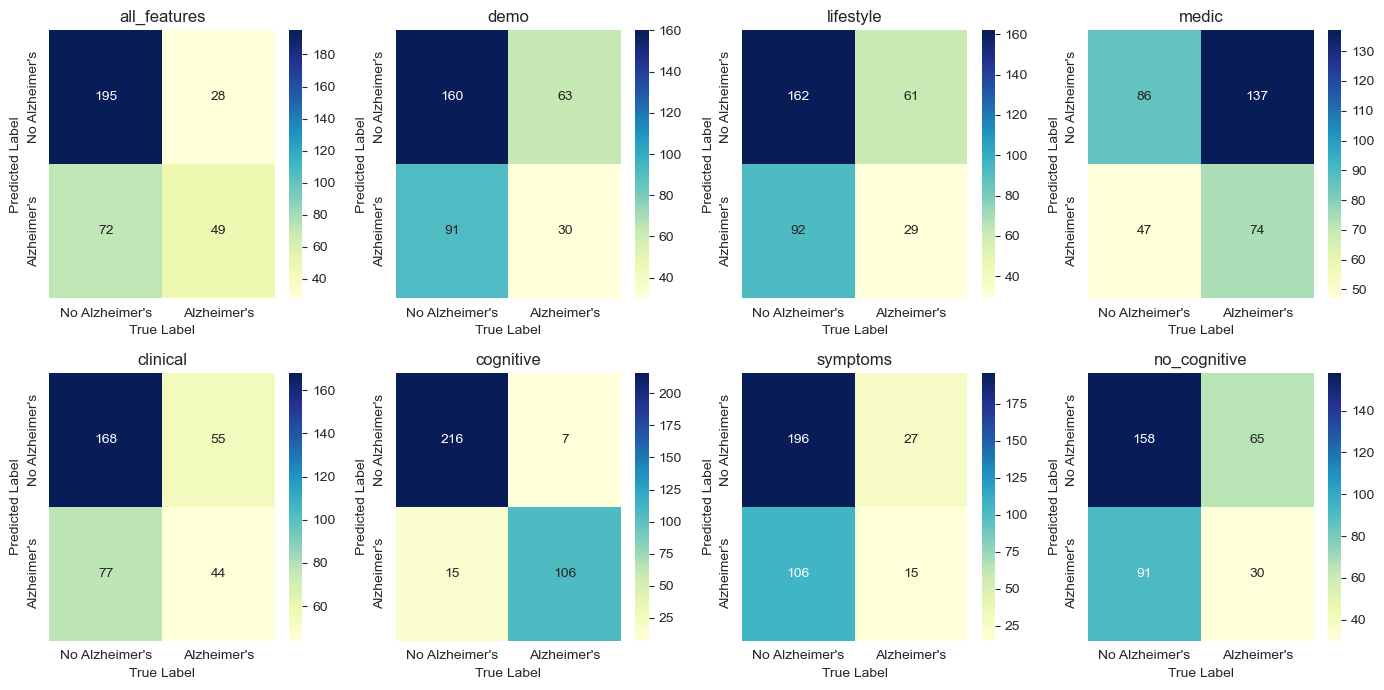

In [152]:
# Define hyperparameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10, 15]
}

# Store metrics and confusion matrices
knn_metrics = {}
knn_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    knn_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    # GridSearchCV
    grid = GridSearchCV(knn_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    knn_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['knn__n_neighbors']
    ]

    # Store confusion matrix
    knn_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
knn_metrics_df = pd.DataFrame(
    knn_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best n_neighbors']
)
display(knn_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(knn_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(knn_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Decision Trees

We’ll tune the max_depth parameter using GridSearchCV.

all_features      demo  lifestyle     medic  clinical  \
Accuracy            0.941860  0.531977   0.552326  0.654070  0.529070   
Precision           0.939130  0.303922   0.377778  0.750000  0.341085   
Recall              0.892562  0.256198   0.421488  0.024793  0.363636   
F1 Score            0.915254  0.278027   0.398438  0.048000  0.352000   
Best Max Depth      5.000000       NaN        NaN  5.000000       NaN   

                cognitive  symptoms  no_cognitive  
Accuracy         0.950581  0.648256      0.537791  
Precision        0.964286  0.000000      0.344262  
Recall           0.892562  0.000000      0.347107  
F1 Score         0.927039  0.000000      0.345679  
Best Max Depth   5.000000  5.000000           NaN

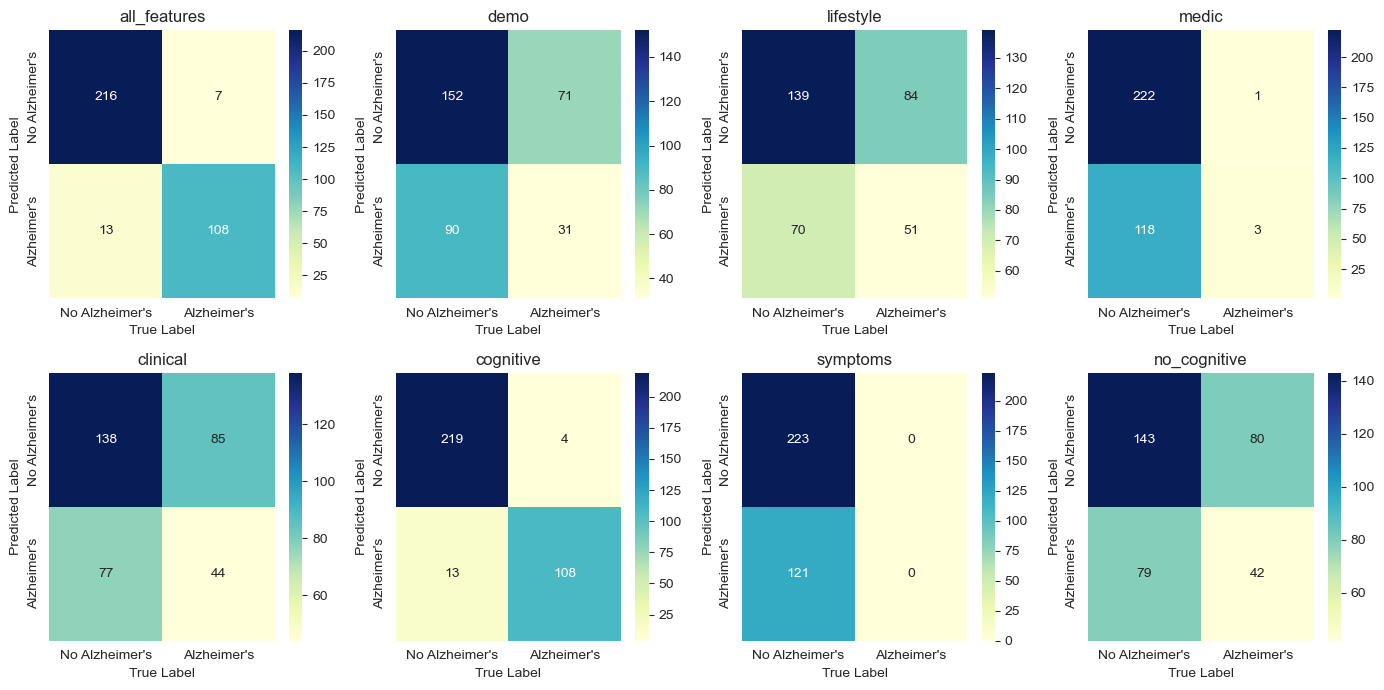

In [154]:
# Define hyperparameter grid
param_grid = {
    'dt__max_depth': [3, 5, 8, 10, 12, None]
}

# Store metrics and confusion matrices
dt_metrics = {}
dt_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    dt_pipe = Pipeline([
        ('scale', StandardScaler()),  # included for consistency
        ('dt', DecisionTreeClassifier(random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(dt_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    dt_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['dt__max_depth']
    ]

    # Store confusion matrix
    dt_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
dt_metrics_df = pd.DataFrame(
    dt_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Max Depth']
)
display(dt_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(dt_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(dt_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Gaussian Naǐve Bayes

all_features      demo  lifestyle     medic  clinical  cognitive  \
Accuracy       0.831395  0.648256   0.648256  0.633721  0.648256   0.834302   
Precision      0.778761  0.000000   0.000000  0.272727  0.000000   0.785714   
Recall         0.727273  0.000000   0.000000  0.024793  0.000000   0.727273   
F1 Score       0.752137  0.000000   0.000000  0.045455  0.000000   0.755365   

           symptoms  no_cognitive  
Accuracy   0.648256      0.613372  
Precision  0.000000      0.300000  
Recall     0.000000      0.074380  
F1 Score   0.000000      0.119205

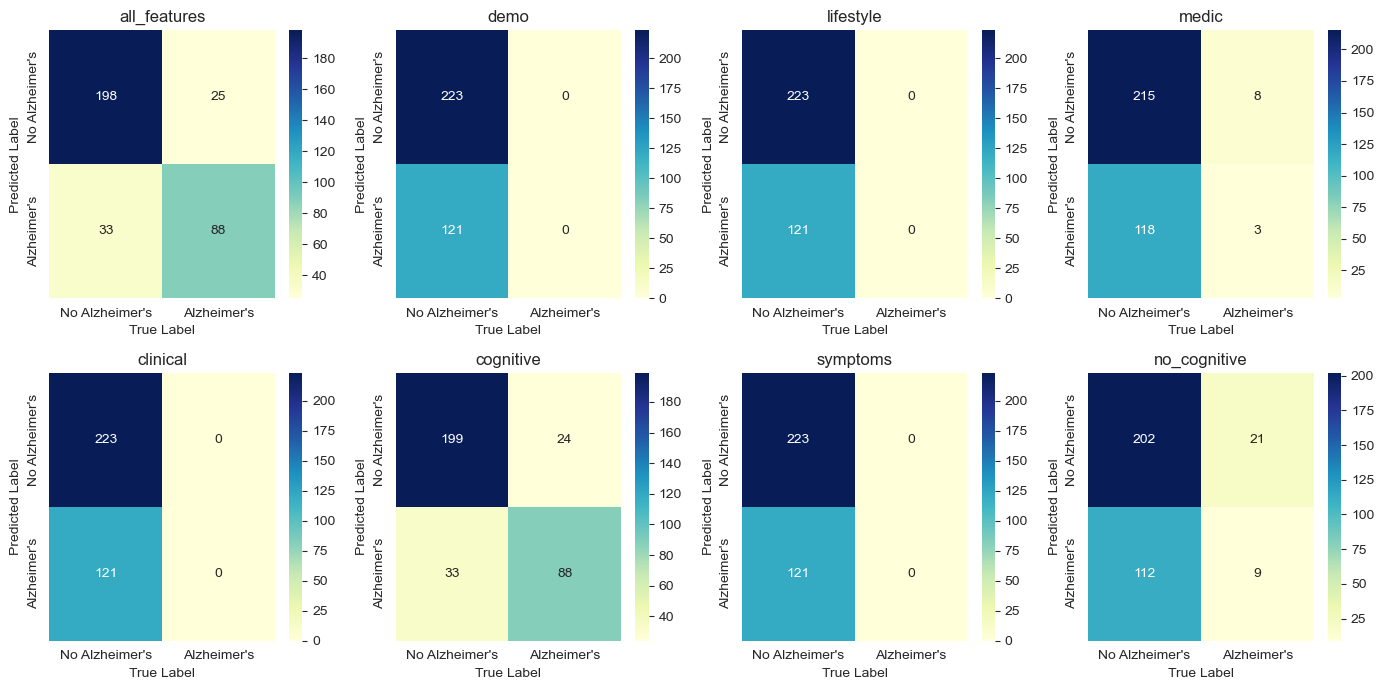

In [36]:
# Pipeline
gnb_pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('gnb', GaussianNB())
])

# Store metrics and confusion matrices
gnb_metrics = {}
gnb_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    gnb_pipe.fit(df_train[features[:-1]], df_train.Diagnosis)
    pred = gnb_pipe.predict(df_test[features[:-1]])

    # Store metrics
    gnb_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0)
    ]

    # Store confusion matrix
    gnb_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
gnb_metrics_df = pd.DataFrame(gnb_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(gnb_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(gnb_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
               xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(key)
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(gnb_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Linear Discriminant Analysis (LDA)

all_features      demo  lifestyle     medic  clinical  cognitive  \
Accuracy       0.843023  0.648256   0.648256  0.648256  0.648256   0.845930   
Precision      0.791304  0.000000   0.000000  0.000000  0.000000   0.814815   
Recall         0.752066  0.000000   0.000000  0.000000  0.000000   0.727273   
F1 Score       0.771186  0.000000   0.000000  0.000000  0.000000   0.768559   

           symptoms  no_cognitive  
Accuracy   0.648256      0.645349  
Precision  0.000000      0.000000  
Recall     0.000000      0.000000  
F1 Score   0.000000      0.000000

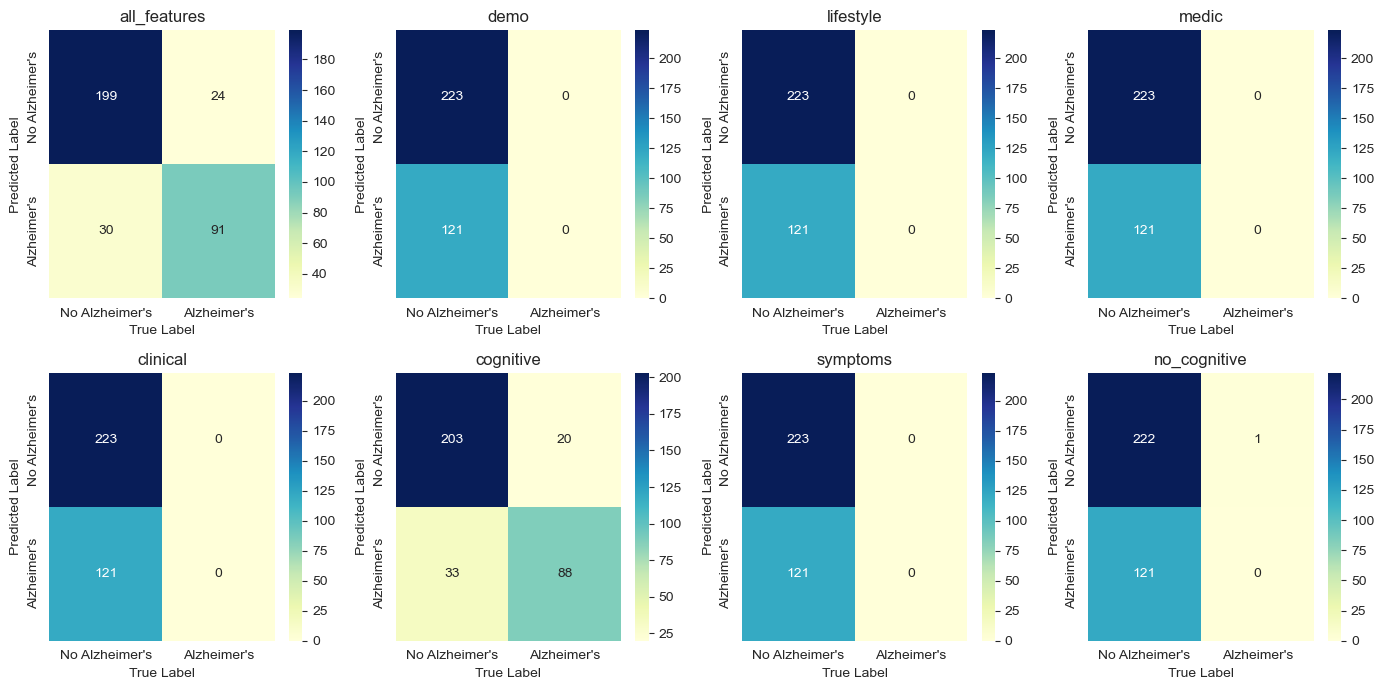

In [38]:
# Pipeline
lda_pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('lda', LinearDiscriminantAnalysis())
])

# Store metrics and confusion matrices
lda_metrics = {}
lda_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    lda_pipe.fit(df_train[features[:-1]], df_train.Diagnosis)
    pred = lda_pipe.predict(df_test[features[:-1]])

    # Store metrics
    lda_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0)
    ]

    # Store confusion matrix
    lda_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
lda_metrics_df = pd.DataFrame(lda_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(lda_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(lda_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
               xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(key)
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(lda_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Quadtratic Discriminant Analysis (QDA)

all_features      demo  lifestyle     medic  clinical  cognitive  \
Accuracy       0.805233  0.648256   0.636628  0.636628  0.651163   0.848837   
Precision      0.732759  0.000000   0.166667  0.375000  0.545455   0.785124   
Recall         0.702479  0.000000   0.008264  0.049587  0.049587   0.785124   
F1 Score       0.717300  0.000000   0.015748  0.087591  0.090909   0.785124   

           symptoms  no_cognitive  
Accuracy   0.648256      0.587209  
Precision  0.000000      0.367089  
Recall     0.000000      0.239669  
F1 Score   0.000000      0.290000

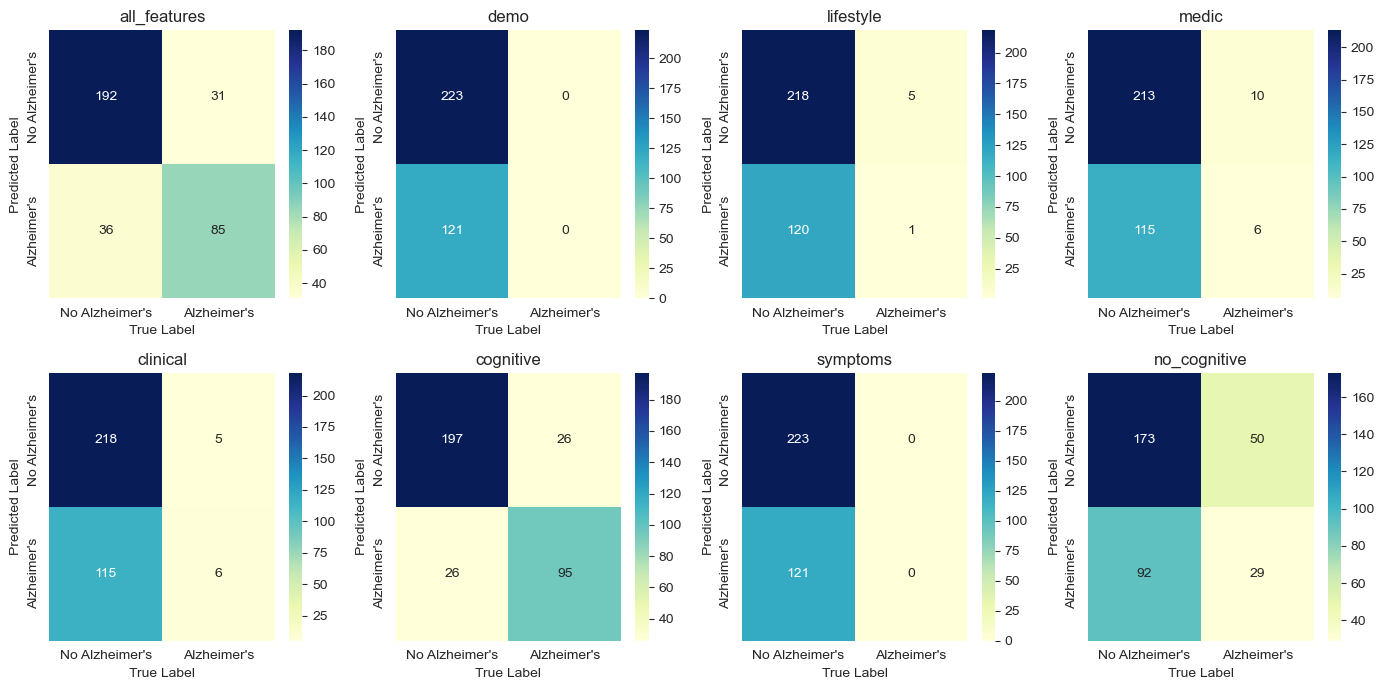

In [40]:
# Pipeline
qda_pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('qda', QuadraticDiscriminantAnalysis())
])

# Store metrics and confusion matrices
qda_metrics = {}
qda_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    qda_pipe.fit(df_train[features[:-1]], df_train.Diagnosis)
    pred = qda_pipe.predict(df_test[features[:-1]])

    # Store metrics
    qda_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0)
    ]

    # Store confusion matrix
    qda_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
qda_metrics_df = pd.DataFrame(qda_metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(qda_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(qda_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(key)
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(qda_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Support Vector Machines (SVM)

In this section, we explore Support Vector Machines (SVM) using different kernel functions, with the goal of identifying the best-performing model for each feature subcategory. For each kernel, we perform hyperparameter tuning using GridSearchCV to optimize model performance based on F1 score.

We evaluate the following kernel types:

- Polynomial kernel (degrees 1 to 4)
- Radial Basis Function (RBF) kernel
- Sigmoid kernel

Each kernel is tested across various regularization and kernel-specific parameters.

## Polynomial Kernel

all_features        demo   lifestyle       medic    clinical  \
Accuracy         0.857558    0.648256    0.619186    0.645349    0.642442   
Precision        0.827273    0.000000    0.250000    0.454545    0.450000   
Recall           0.752066    0.000000    0.041322    0.041322    0.074380   
F1 Score         0.787879    0.000000    0.070922    0.075758    0.127660   
Best C         100.000000  100.000000  100.000000  100.000000  100.000000   
Best Degree      1.000000    1.000000    4.000000    3.000000    4.000000   

              cognitive    symptoms  no_cognitive  
Accuracy       0.886628    0.648256      0.537791  
Precision      0.945652    0.000000      0.336207  
Recall         0.719008    0.000000      0.322314  
F1 Score       0.816901    0.000000      0.329114  
Best C       100.000000  100.000000    100.000000  
Best Degree    4.000000    4.000000      3.000000

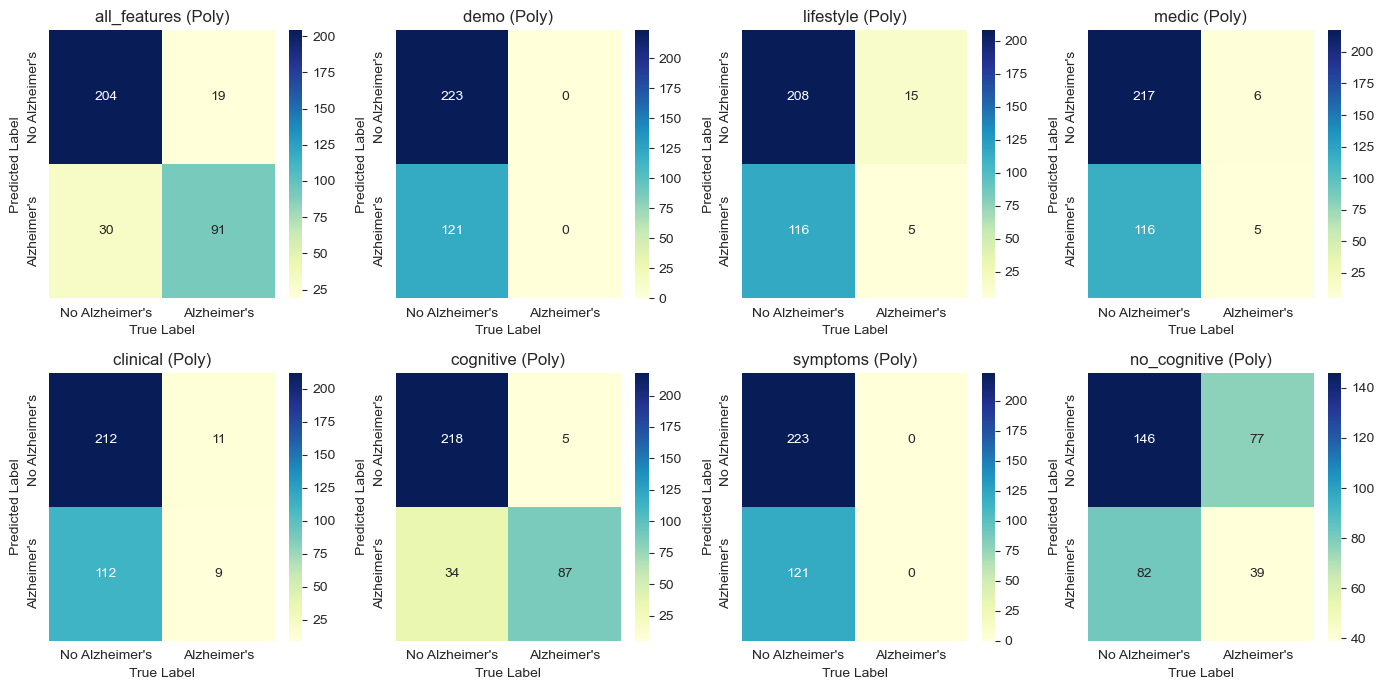

In [156]:
# Define hyperparameter grid
param_grid = {
    'svc__C': [100, 10, 1, 0.1, 0.01],
    'svc__degree': [1, 2, 3, 4],
    'svc__kernel': ['poly']
}

# Store metrics and confusion matrices
svm_poly_metrics = {}
svm_poly_conf_matrix = {}
svm_poly_best_params = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    poly_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('svc', SVC())                           # Note: User may add max_iter parameter here to make it converge faster.
    ])

    # GridSearchCV
    grid = GridSearchCV(poly_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    svm_poly_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['svc__C'],
        best_params['svc__degree']
    ]

    # Store confusion matrix
    svm_poly_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
svm_poly_metrics_df = pd.DataFrame(
    svm_poly_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best C', 'Best Degree']
)
display(svm_poly_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(svm_poly_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key} (Poly)")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(svm_poly_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Gaussian RBF

all_features        demo  lifestyle       medic   clinical  \
Accuracy        0.860465    0.616279   0.549419    0.645349   0.590116   
Precision       0.828829    0.412698   0.345455    0.454545   0.418033   
Recall          0.760331    0.214876   0.314050    0.041322   0.421488   
F1 Score        0.793103    0.282609   0.329004    0.075758   0.419753   
Best C        100.000000  100.000000  10.000000  100.000000  10.000000   
Best Gamma      0.001000    1.000000   1.000000    0.100000   1.000000   

            cognitive    symptoms  no_cognitive  
Accuracy     0.947674    0.648256      0.546512  
Precision    0.955752    0.000000      0.336449  
Recall       0.892562    0.000000      0.297521  
F1 Score     0.923077    0.000000      0.315789  
Best C       1.000000  100.000000    100.000000  
Best Gamma   1.000000    1.000000      0.010000

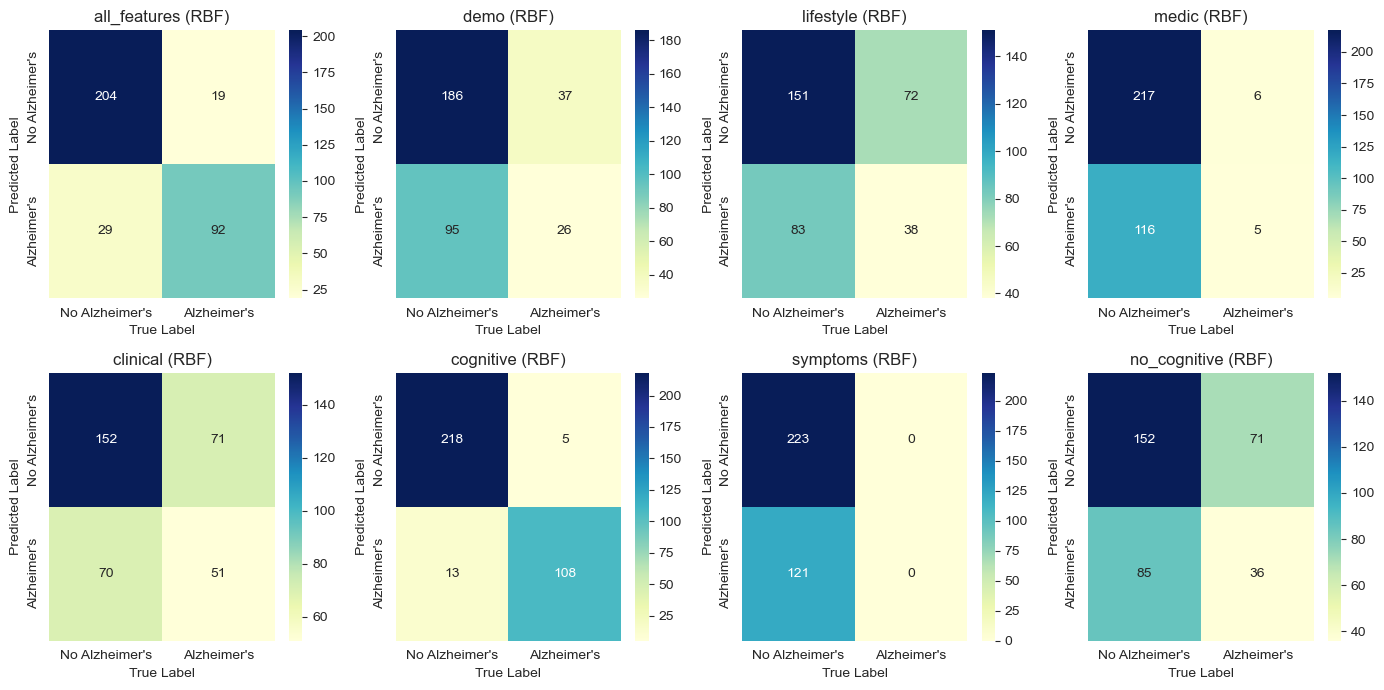

In [158]:
# Define hyperparameter grid
param_grid = {
    'svc__C': [100, 10, 1, 0.1, 0.01],
    'svc__gamma': [1, 0.1, 0.01, 0.001],
    'svc__kernel': ['rbf']
}

# Store metrics and confusion matrices
svm_rbf_metrics = {}
svm_rbf_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    rbf_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('svc', SVC())                             # Note: User may add max_iter parameter here to make it converge faster.
    ])

    # GridSearchCV
    grid = GridSearchCV(rbf_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    svm_rbf_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['svc__C'],
        best_params['svc__gamma']
    ]

    # Store confusion matrix
    svm_rbf_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
svm_rbf_metrics_df = pd.DataFrame(
    svm_rbf_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score','Best C', 'Best Gamma']
)
display(svm_rbf_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(svm_rbf_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key} (RBF)")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(svm_rbf_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Sigmoid Kernel

all_features        demo  lifestyle       medic  clinical  \
Accuracy        0.866279    0.549419   0.563953    0.619186  0.537791   
Precision       0.844037    0.371212   0.376068    0.386364  0.344262   
Recall          0.760331    0.404959   0.363636    0.140496  0.347107   
F1 Score        0.800000    0.387352   0.369748    0.206061  0.345679   
Best C        100.000000  100.000000   1.000000  100.000000  1.000000   
Best Gamma      0.001000    0.100000   1.000000    0.100000  1.000000   
Best Coef0     -1.000000    1.000000   1.000000    1.000000 -1.000000   

             cognitive  symptoms  no_cognitive  
Accuracy      0.866279  0.511628      0.581395  
Precision     0.815126  0.337931      0.403361  
Recall        0.801653  0.404959      0.396694  
F1 Score      0.808333  0.368421      0.400000  
Best C      100.000000  0.100000    100.000000  
Best Gamma    0.100000  1.000000      0.100000  
Best Coef0   -1.000000  1.000000      1.000000

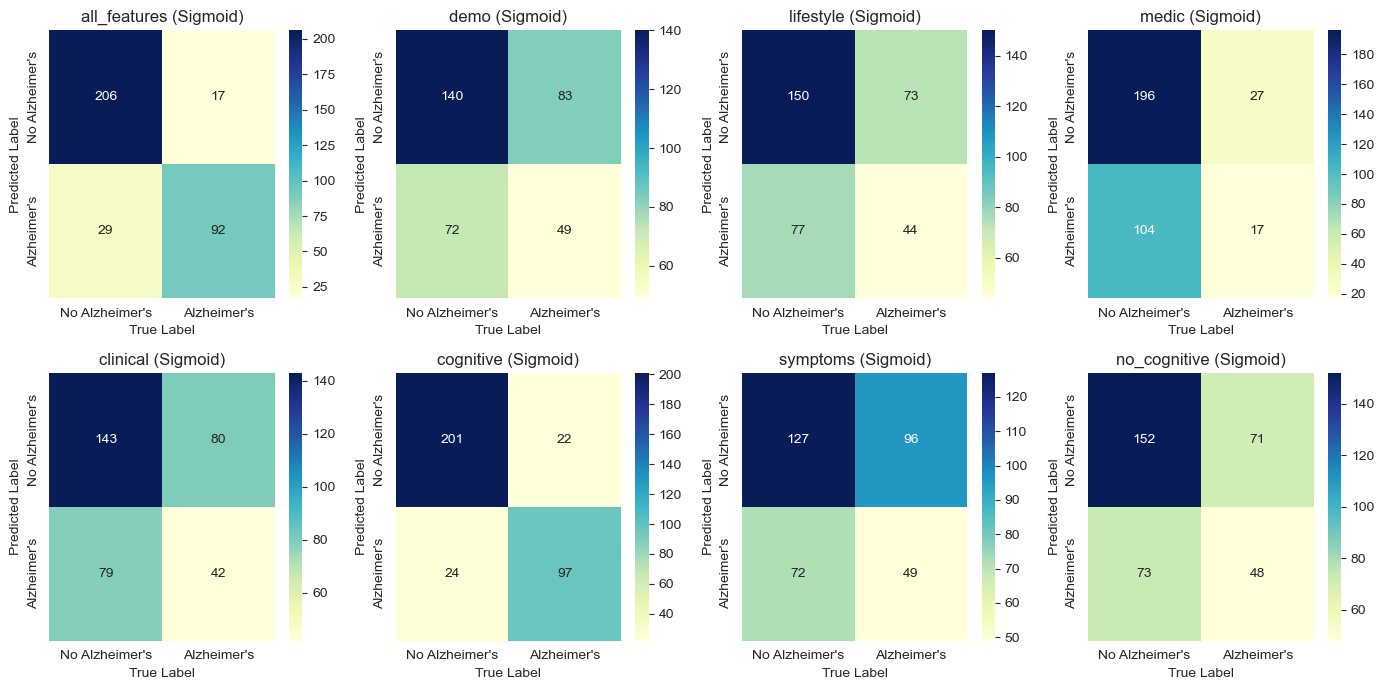

In [161]:
# Define hyperparameter grid
param_grid = {
    'svc__C': [100, 10, 1, 0.1, 0.01],
    'svc__gamma': [1, 0.1, 0.01, 0.001],
    'svc__coef0': [-1, 0, 1],
    'svc__kernel': ['sigmoid']
}

# Store metrics and confusion matrices
svm_sigmoid_metrics = {}
svm_sigmoid_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    sigmoid_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('svc', SVC())                            # Note: User may add max_iter parameter here to make it converge faster.
    ])

    # GridSearchCV
    grid = GridSearchCV(sigmoid_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    svm_sigmoid_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['svc__C'],
        best_params['svc__gamma'],
        best_params['svc__coef0']
    ]

    # Store confusion matrix
    svm_sigmoid_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
svm_sigmoid_metrics_df = pd.DataFrame(
    svm_sigmoid_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best C', 'Best Gamma', 'Best Coef0']
)
display(svm_sigmoid_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(svm_sigmoid_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key} (Sigmoid)")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(svm_sigmoid_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Stochastic Gradient Descent Classifier

We’ll tune the regularization strength alpha and the penalty parameters using GridSearchCV. User may also tune the loss function, but we use hinge loss here.

all_features      demo lifestyle       medic  clinical cognitive  \
Accuracy         0.822674  0.648256  0.622093    0.648256  0.651163  0.837209   
Precision            0.75       0.0  0.378378         0.0  0.529412  0.787611   
Recall           0.743802       0.0  0.115702         0.0   0.07438  0.735537   
F1 Score         0.746888       0.0  0.177215         0.0  0.130435  0.760684   
Best Alpha          0.001    0.0001    0.0001      0.0001    0.0001      0.01   
Best Penalty           l1        l1        l2  elasticnet        l2        l1   

              symptoms no_cognitive  
Accuracy      0.633721     0.616279  
Precision     0.272727     0.382979  
Recall        0.024793      0.14876  
F1 Score      0.045455     0.214286  
Best Alpha      0.0001       0.0001  
Best Penalty        l2   elasticnet

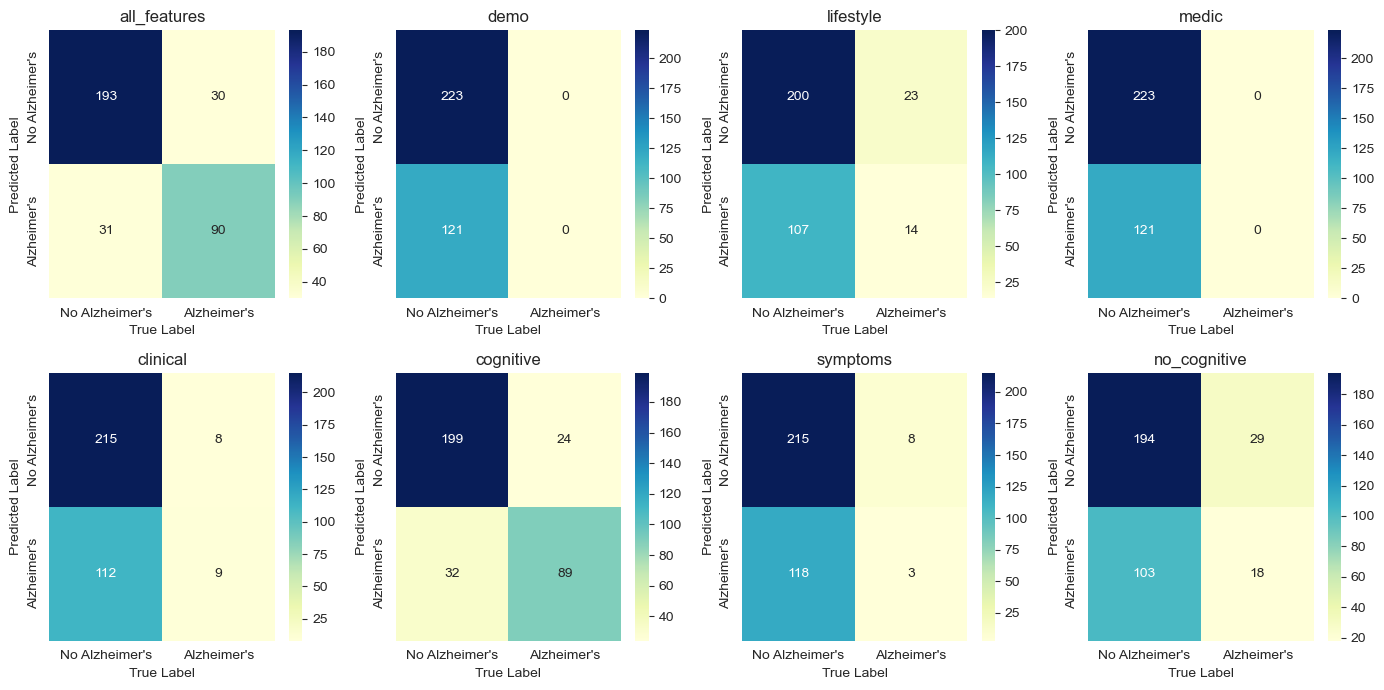

In [163]:
# Define hyperparameter grid
param_grid = {
    'sgd__alpha': [0.0001, 0.001, 0.01],
    'sgd__penalty': ['l2', 'l1', 'elasticnet']
}

# Store metrics and confusion matrices
sgd_metrics = {}
sgd_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    sgd_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sgd', SGDClassifier(loss='hinge', random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(sgd_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    sgd_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['sgd__alpha'],
        best_params['sgd__penalty']
    ]

    # Store confusion matrix
    sgd_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
sgd_metrics_df = pd.DataFrame(
    sgd_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Alpha', 'Best Penalty']
)
display(sgd_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(sgd_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(sgd_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Random Forest

We’ll tune the max_depth parameter using GridSearchCV.

all_features      demo  lifestyle     medic  clinical  \
Accuracy            0.944767  0.534884   0.619186  0.645349  0.627907   
Precision           0.972222  0.330435   0.375000  0.444444  0.410256   
Recall              0.867769  0.314050   0.123967  0.033058  0.132231   
F1 Score            0.917031  0.322034   0.186335  0.061538  0.200000   
Best Max Depth           NaN       NaN        NaN  8.000000       NaN   

                cognitive  symptoms  no_cognitive  
Accuracy         0.950581  0.639535      0.625000  
Precision        0.964286  0.200000      0.277778  
Recall           0.892562  0.008264      0.041322  
F1 Score         0.927039  0.015873      0.071942  
Best Max Depth   8.000000  5.000000           NaN

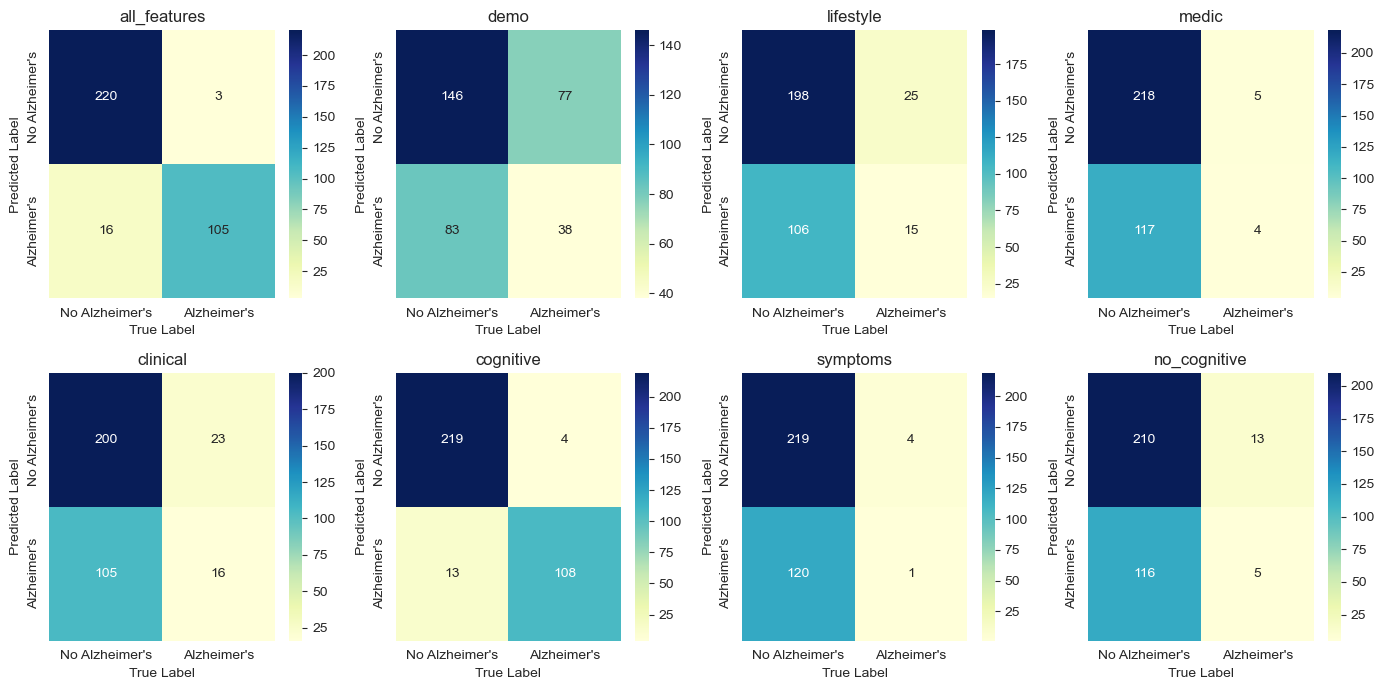

In [165]:
# Define hyperparameter grid
param_grid = {
    'rf__max_depth': [3, 5, 8, 10, 12, None]
}

# Store metrics and confusion matrices
rf_metrics = {}
rf_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    rf_pipe = Pipeline([
        ('scale', StandardScaler()),  # included for consistency
        ('rf', RandomForestClassifier(random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    rf_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['rf__max_depth']
    ]

    # Store confusion matrix
    rf_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
rf_metrics_df = pd.DataFrame(
    rf_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Max Depth']
)
display(rf_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(rf_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(rf_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Gradient Boosting Classifier (GBC)

We use GridSearchCV to find the best parameters max_depth and learning_rate.

all_features      demo  lifestyle     medic  clinical  \
Accuracy                0.927326  0.520349   0.581395  0.645349  0.601744   
Precision               0.900000  0.310345   0.386139  0.454545  0.425926   
Recall                  0.892562  0.297521   0.322314  0.041322  0.380165   
F1 Score                0.896266  0.303797   0.351351  0.075758  0.401747   
Best Learning Rate      0.900000  0.900000   0.900000  0.900000  0.900000   
Best Max Depth          3.000000  8.000000   3.000000  3.000000  3.000000   

                    cognitive  symptoms  no_cognitive  
Accuracy             0.950581  0.639535      0.555233  
Precision            0.933333  0.200000      0.340000  
Recall               0.925620  0.008264      0.280992  
F1 Score             0.929461  0.015873      0.307692  
Best Learning Rate   0.900000  0.100000      0.900000  
Best Max Depth       8.000000  3.000000      3.000000

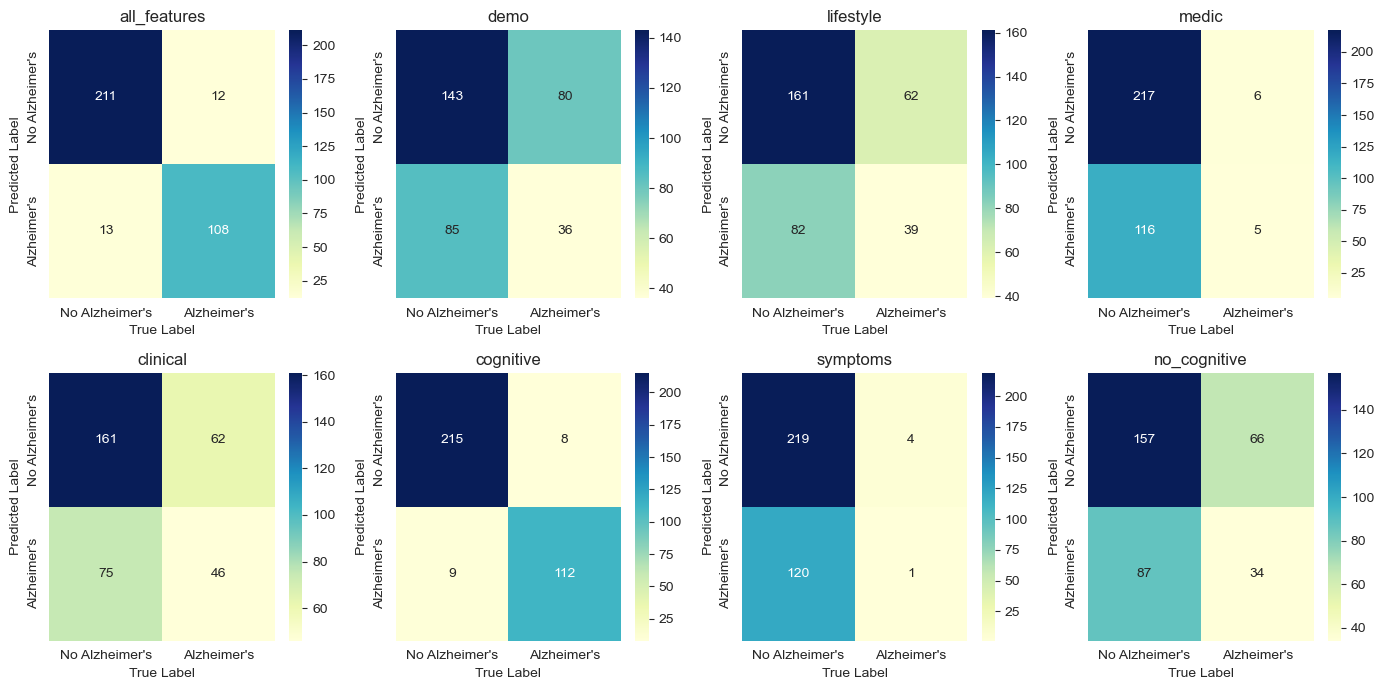

In [191]:
# Warning: This cell takes long to run!

# Define hyperparameter grid
param_grid = {
    'gb__learning_rate': [0.01, 0.1, 0.9],     # Note: User may reduce the number of parameters to get faster convergence.
    'gb__max_depth': [3, 8, 10]
}

# Store metrics and confusion matrices
gb_metrics = {}
gb_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    gb_pipe = Pipeline([
        ('scale', StandardScaler()),  
        ('gb', GradientBoostingClassifier(random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(gb_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    gb_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['gb__learning_rate'],
        best_params['gb__max_depth']
    ]

    # Store confusion matrix
    gb_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
gb_metrics_df = pd.DataFrame(
    gb_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Learning Rate', 'Best Max Depth']
)
display(gb_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(gb_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(gb_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Adaptive Boosting (AdaBoost)

We use Decision Tree classifier as the base estimator and try to optimize the learning_rate and the base estimator max_depth.

all_features      demo  lifestyle     medic  clinical  \
Accuracy                0.959302  0.563953   0.584302  0.639535  0.595930   
Precision               0.965217  0.353535   0.375000  0.384615  0.387500   
Recall                  0.917355  0.289256   0.272727  0.041322  0.256198   
F1 Score                0.940678  0.318182   0.315789  0.074627  0.308458   
Best Learning Rate      0.050000  1.000000   0.900000  0.500000  1.000000   
Best Max Depth          5.000000  5.000000   5.000000  5.000000  5.000000   

                    cognitive  symptoms  no_cognitive  
Accuracy             0.950581  0.639535      0.572674  
Precision            0.964286  0.200000      0.324324  
Recall               0.892562  0.008264      0.198347  
F1 Score             0.927039  0.015873      0.246154  
Best Learning Rate   0.050000  1.000000      1.000000  
Best Max Depth       3.000000  5.000000      3.000000

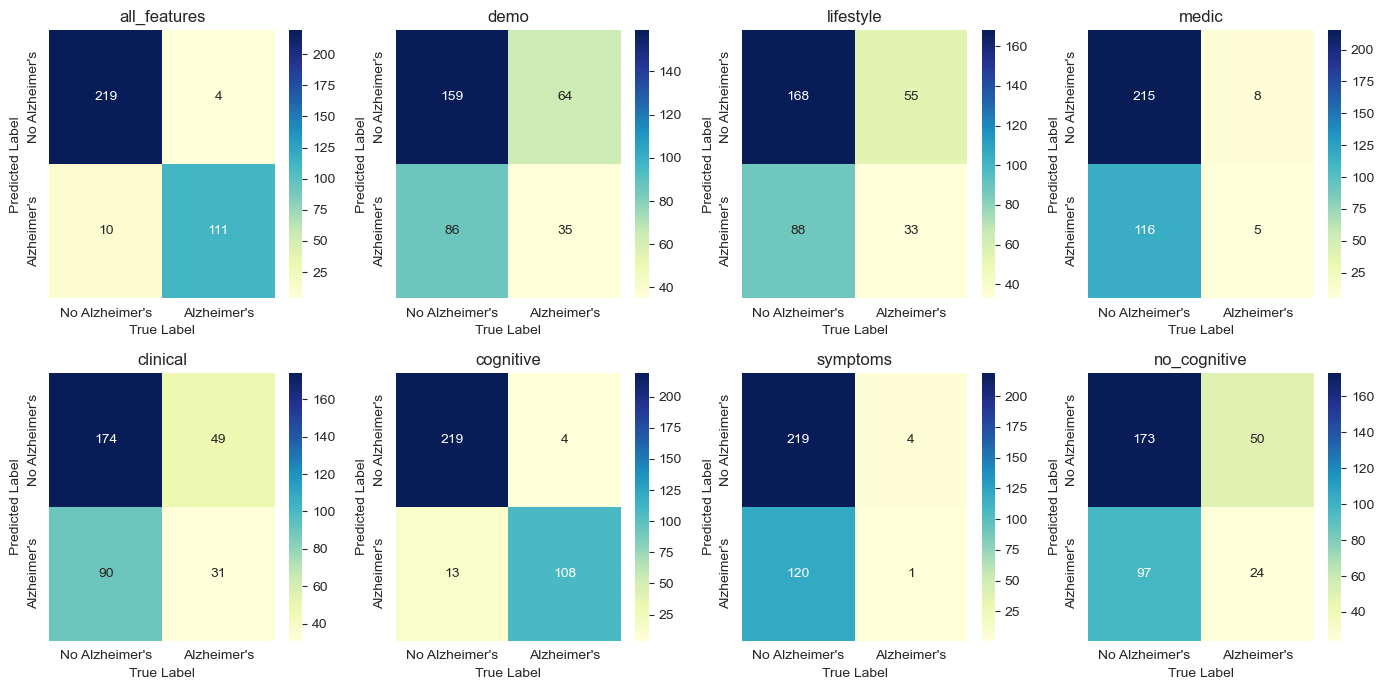

In [217]:
# Warning: This cell takes long to run!

# Define hyperparameter grid
param_grid = {
    'ab__learning_rate': [0.05, 0.1, 0.5, 0.8, 0.9, 1.0],    # Note: User may reduce the number of parameters to get faster convergence.
    'ab__estimator__max_depth': [2, 3, 5]
}

# Store metrics and confusion matrices
ab_metrics = {}
ab_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline with custom base estimator
    ab_pipe = Pipeline([
        ('scale', StandardScaler()),  
        ('ab', AdaBoostClassifier(
            estimator=DecisionTreeClassifier(),
            n_estimators=200,
            algorithm='SAMME',
            random_state=123
        ))
    ])

    # GridSearchCV
    grid = GridSearchCV(ab_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    ab_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['ab__learning_rate'],
        best_params['ab__estimator__max_depth']
    ]

    # Store confusion matrix
    ab_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
ab_metrics_df = pd.DataFrame(
    ab_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Learning Rate', 'Best Max Depth']
)
display(ab_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(ab_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(ab_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Extreme Gradient Boosting (XGBoost)

all_features       demo  lifestyle     medic  clinical  \
Accuracy                0.950581   0.514535   0.610465  0.648256  0.601744   
Precision               0.956140   0.290909   0.408451  0.500000  0.406977   
Recall                  0.900826   0.264463   0.239669  0.024793  0.289256   
F1 Score                0.927660   0.277056   0.302083  0.047244  0.338164   
Best Learning Rate      0.200000   0.100000   0.200000  0.050000  0.200000   
Best Max Depth         10.000000  10.000000  10.000000  7.000000  7.000000   

                    cognitive  symptoms  no_cognitive  
Accuracy             0.959302  0.648256      0.598837  
Precision            0.965217  0.000000      0.339623  
Recall               0.917355  0.000000      0.148760  
F1 Score             0.940678  0.000000      0.206897  
Best Learning Rate   0.100000  0.100000      0.200000  
Best Max Depth       3.000000  7.000000      3.000000

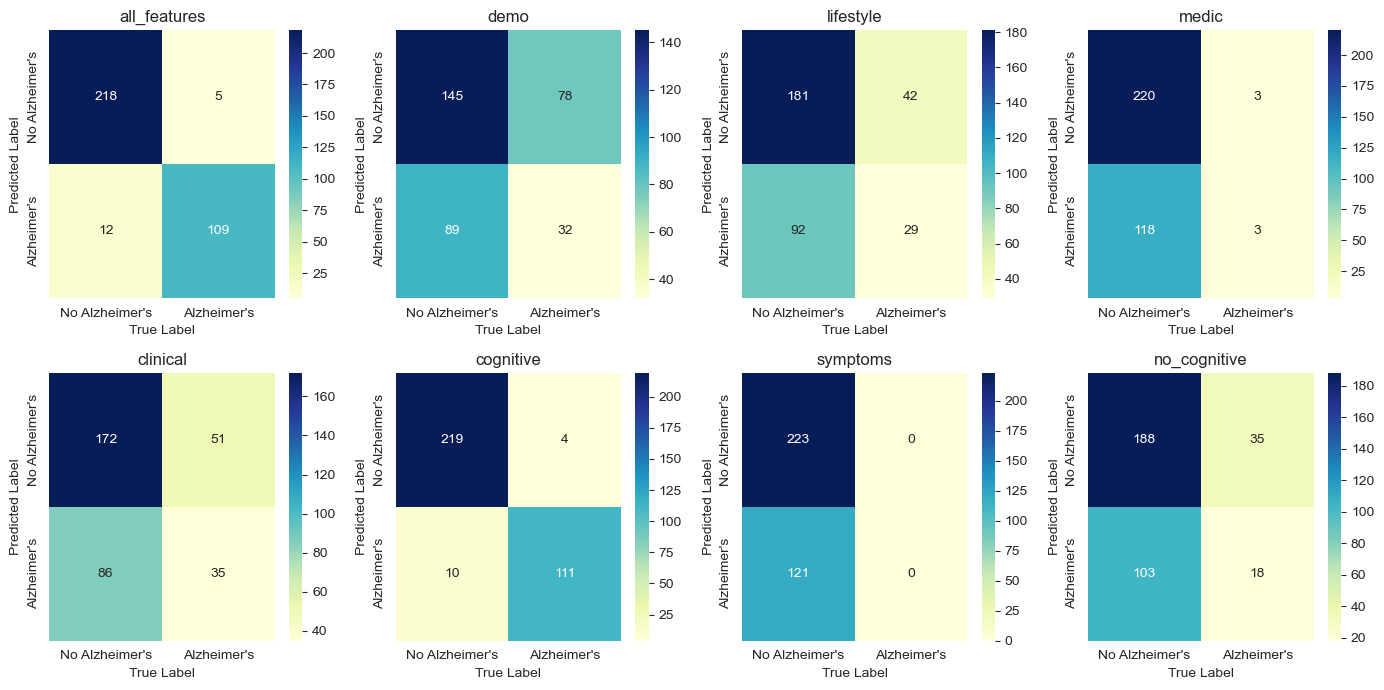

In [198]:
# Warning: This cell takes long to run!

# Define hyperparameter grid
param_grid = {
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__max_depth': [3, 7, 10]
}

# Store metrics and confusion matrices
xgb_metrics = {}
xgb_conf_matrix = {}

# Run classifier across feature subcategories
for key, features in subcategory_dict.items():
    # Define pipeline
    xgb_pipe = Pipeline([
        ('scale', StandardScaler()),  
        ('xgb', XGBClassifier(random_state=123))
    ])

    # GridSearchCV
    grid = GridSearchCV(xgb_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(df_train[features[:-1]], df_train.Diagnosis)
    best_model = grid.best_estimator_
    best_params = grid.best_params_

    # Predict
    pred = best_model.predict(df_test[features[:-1]])

    # Store metrics
    xgb_metrics[key] = [
        accuracy_score(df_test.Diagnosis, pred),
        precision_score(df_test.Diagnosis, pred, zero_division=0),
        recall_score(df_test.Diagnosis, pred, zero_division=0),
        f1_score(df_test.Diagnosis, pred, zero_division=0),
        best_params['xgb__learning_rate'],
        best_params['xgb__max_depth']
    ]

    # Store confusion matrix
    xgb_conf_matrix[key] = confusion_matrix(df_test.Diagnosis, pred)

# Display metrics in a dataframe
xgb_metrics_df = pd.DataFrame(
    xgb_metrics,
    index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Learning Rate', 'Best Max Depth']
)
display(xgb_metrics_df)

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (key, cm) in enumerate(xgb_conf_matrix.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[idx],
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    axes[idx].set_title(f"{key}")
    axes[idx].set_xlabel("True Label")
    axes[idx].set_ylabel("Predicted Label")

for i in range(len(xgb_conf_matrix), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Summary of explored models

In [219]:
summary_df = pd.DataFrame({
    'Logistic Regression': logreg_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'KNN': knn_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Decision Trees': dt_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Gaussian Naǐve Bayes': gnb_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'LDA': lda_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'QDA': qda_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'SVM': svm_poly_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Stochastic Gradient Descent': sgd_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Random Forest': rf_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'Gradient Boosting': gb_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'AdaBoost': ab_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']],
    'XGBoost': xgb_metrics_df['all_features'].loc[['Accuracy', 'F1 Score']]
}).T

summary_df.columns = ['Accuracy', 'F1 Score']
display(summary_df.sort_values(by='Accuracy', ascending=False).round(3))

Accuracy  F1 Score
AdaBoost                     0.959302  0.940678
XGBoost                      0.950581   0.92766
Random Forest                0.944767  0.917031
Decision Trees                0.94186  0.915254
Gradient Boosting            0.927326  0.896266
Logistic Regression          0.860465  0.793103
SVM                          0.857558  0.787879
LDA                          0.843023  0.771186
Gaussian Naǐve Bayes         0.831395  0.752137
Stochastic Gradient Descent  0.822674  0.746888
QDA                          0.805233    0.7173
KNN                          0.709302  0.494949

**Conclusion:** Upon initial model exploration, our best performing model for the entire dataset of patients (including those who had memory complaints) is **AdaBoost**.